# Create a Hovmoeller diagram

In [1]:
from importlib import reload
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy as ctp
import locale

from climvae.utils import utenso, preproc, eof, utdata, utstats, metric
import climvae.vaeplot as vpl

locale.setlocale(locale.LC_TIME, "en_US.utf8")
plt.style.use("../../paper.mplstyle")

def warm_pool_edge(profile: xr.DataArray, T: float=29) -> float:
    """Identify the warm pool edge.
    
    The function returns the longitude, when the temperature profile exceeds the
    threshold T, from right to left (east to west).

    Args:
        profile (xr.DataArray): SST temperatur profile.
        T (float, optional): Temperature threshold for warm pool. Defaults to 29.

    Returns:
        float: Longitude when profile exceeds threshold
    """
    for lon in profile['lon'].data[::-1]:
        if profile.sel(lon=lon) >= T: 
            thermocline = lon
            break
        else:
            thermocline = np.nan
            continue
    return thermocline

In [2]:
# Load data
# =======================================================================================
reload(preproc)
vars = ['sst', 'ssh']  # , 'ssh', 'olr']
climatology = 'month'
source = 'ORAS5'
lon_range=[130, -70]
lat_range=[-32, 32]

dirpath = "../../data/sst/monthly"
data_filenames = {
    'COBE2':    dirpath+"/sst_cobe2_month_1850-2019.nc",
    'ErSSTv5':  dirpath+"/sst_ersstv5_month_1854-present.nc",
    'HadISST':  dirpath+"/sst_hadisst_month_1870-present.nc",
    'ORAS5':    f"../../data/multivar/oceanvars_ORAS5_1x1.nc",
    'GODAS':    f"../../data/multivar/oceanvars_GODAS_1x1.nc",
    'SODA':     f"../../data/multivar/oceanvars_SODA_1x1.nc",
    'ERA5':     dirpath+"/sea_surface_temperature_era5_monthly_sp_1940-2022_1.0x1.0.nc",
    'CERA-20c': f"../../data/multivar/oceanvars_CERA20C_1x1.nc",
    # dict(name='tropflux',path=dirpath+"/sst_tropflux_month_1979-2018.nc"),
}

# Anomalies
ds = preproc.process_data(
        data_filenames[source], vars=vars, antimeridian=True,
        climatology='month', normalization=None, detrend_from=1950, 
        lon_range=lon_range, lat_range=lat_range,
)

# SST temperatures for warm pool edge detection
ds_sst = preproc.process_data(
        data_filenames[source], vars=['sst'], antimeridian=True,
        climatology=None, normalization=None, detrend_from=1950, 
        lon_range=lon_range, lat_range=lat_range,
)

Sort longitudes and latitudes in ascending order, respectively
Process sst:
Roll longitudes.
Set the dateline to the new longitude zero.
Get selected area: lon=[-50 110], lat=[-32, 32]!
Detrend and compute anomalies:
Process ssh:
Roll longitudes.
Set the dateline to the new longitude zero.
Get selected area: lon=[-50 110], lat=[-32, 32]!
Detrend and compute anomalies:
Sort longitudes and latitudes in ascending order, respectively
Process sst:
Roll longitudes.
Set the dateline to the new longitude zero.
Get selected area: lon=[-50 110], lat=[-32, 32]!


## Single event Hovmoeller

Paperplot of EP and EEN events:

/tmp/ipykernel_105519/2128570835.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../../output/reanalysis/pcgmm/hovmoeller/"
/tmp/ipykernel_105519/2128570835.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../../output/reanalysis/pcgmm/hovmoeller/"
/mnt/qb/work/goswami/jschloer46/software/mamba/envs/phdenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


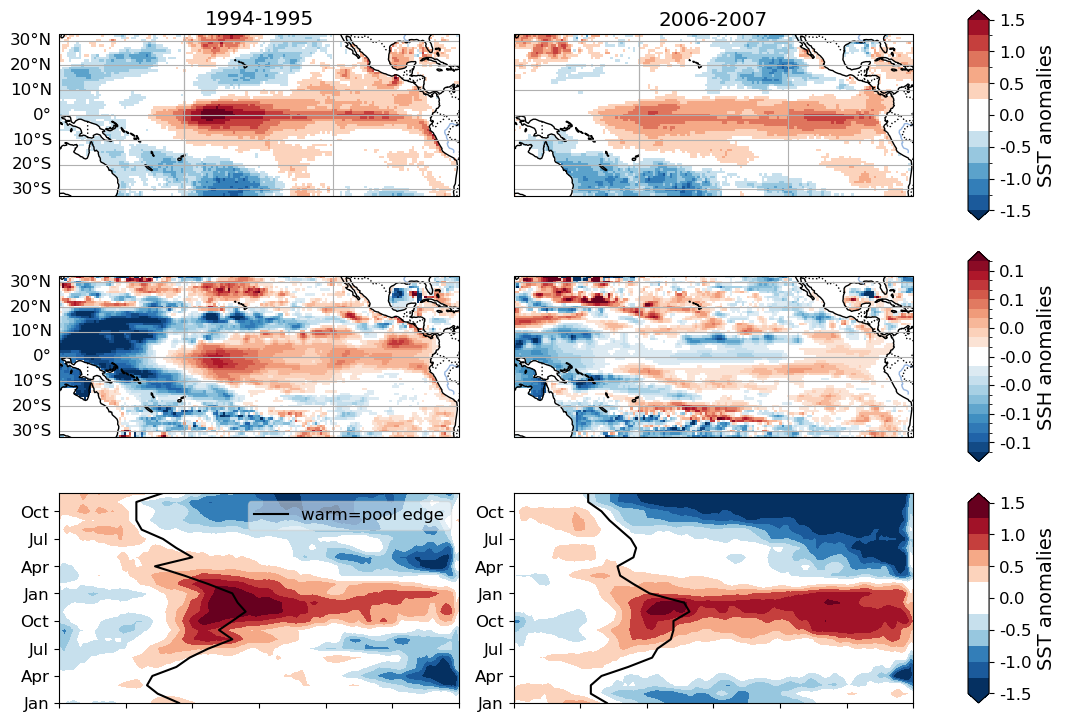

In [56]:
from matplotlib.ticker import FuncFormatter
reload(vpl)

events = [
#    [1987, 1988],
#    [2002, 2003],
#    [2009, 2010],
#    [2018, 2019],
    [1994, 1995],
    [2006, 2007],
]
plotspec={
    'ssta': dict(cmap='RdBu_r', vmin=-1.5, vmax=1.5, step=.25, centercolor="#FFFFFF"),
    'ssha': dict(cmap='RdBu_r', vmin=-.1, vmax=.1, step=.01, centercolor="#FFFFFF"),
}

#events = [
#    [1982, 1983],
#    [1997, 1998],
#    [2015, 2016],
#]
#plotspec={
#    'ssta': dict(cmap='RdBu_r', vmin=-3.5, vmax=3.5, step=.5, centercolor="#FFFFFF"),
#    'ssha': dict(cmap='RdGy_r', vmin=-.3, vmax=.3, step=.05, centercolor="#FFFFFF"),
#}
lat_range=[-5, 5]
yaxislabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep','Oct', 'Nov', 'Dec',
               'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep','Oct', 'Nov', 'Dec']

n_rows = 3 # SST, SSH, SST hovmoeller
n_columns = len(events)
width_ratios = [19]*(n_columns)
width_ratios.append(1)
fig = plt.figure(figsize=(n_columns*6, n_rows*3))
gs = fig.add_gridspec(n_rows, n_columns+1,
                      width_ratios=width_ratios,
                      hspace=0.15, wspace=0.2)

central_longitude = 180
proj = ctp.crs.PlateCarree(central_longitude=central_longitude)

axs = []
ims = []
for i in range(n_columns):
    for j in range(len(ds.data_vars)):
        var = list(ds.data_vars)[j]
        comp = ds[var].sel(
            time=slice(f"{events[i][0]}-12-01", f"{events[i][1]}-02-28")
            ).mean(dim='time')

        ax = fig.add_subplot(gs[j, i], projection=proj)
            
        im = vpl.plot_map(comp, central_longitude=central_longitude, ax=ax,
                          bar='discrete', add_bar=False,
                          **plotspec[var])

        # Remove labels
        im['gl'].top_labels = False
        im['gl'].right_labels = False
        if j < len(ds.data_vars):
            im['gl'].bottom_labels = False
        if i > 0:
            im['gl'].left_labels = False
        
        # Add years to the side
        if j == 0:
            ax.set_title(f"{events[i][0]}-{events[i][1]}")

        ims.append(im)
        axs.append(ax)
    
    # Hovmoeller
    lat_mean = ds['ssta'].sel(
        time=slice(f"{events[i][0]}-01-01", f"{events[i][1]}-12-28"),
        ).sel(lat=slice(lat_range[0], lat_range[1])).mean(dim='lat')

    ax = fig.add_subplot(gs[-1, i])
    im = vpl.plot_hovmoeller(lat_mean, x='lon', y='time',
                             ax=ax, **plotspec['ssta'], add_bar=False)
    ims.append(im)
    axs.append(ax)
    # X-axis
    ax.set_xlim(None, 100)
    xaxis_formatter = FuncFormatter(lambda x, pos: f'{np.where(x < 0, (x % 180),(x % 180 - 180)):.0f}')
    ax.xaxis.set_major_formatter(xaxis_formatter)

    if i < n_rows -1:
        ax.set_xticklabels([])
        
    # Y-axis to month
    ax.yaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))
    
    # Warm pool edge 
    profile = ds_sst['sst'].sel(
        time=slice(f"{events[i][0]}-01-01", f"{events[i][1]}-12-28"),
        ).sel(lat=0, method="nearest")
    thermocline_arr = []
    for t in profile['time']:
        thermocline_arr.append(warm_pool_edge(profile.sel(time=t), T=29))
    thermocline = xr.DataArray(thermocline_arr, coords={'time': lat_mean['time']})
    
    ax.plot(thermocline.data, thermocline['time'], '-k', label='warm=pool edge')

    if i == 0:
        ax.legend(loc=1, fontsize=12)


# Add figure numbering
#_ = vpl.enumerate_subplots(np.array(axs).T, pos_x=0.02, pos_y=1.05, fontsize=14)
        

# Shared colorbar
cbar_labels = ['SST anomalies', 'SSH anomalies', 'SST anomalies']
for j in range(n_rows):
    ax = fig.add_subplot(gs[j, -1])
    cbar = plt.colorbar(ims[j]['im'], orientation='vertical', shrink=0.9,
                        cax=ax, extend='both')
    cbar.set_label(cbar_labels[j], size=14)

    formatter = FuncFormatter(lambda x, pos: f'{x:.1f}')
    cbar.ax.xaxis.set_major_formatter(formatter)
    cbar.ax.yaxis.set_major_formatter(formatter)

plt.savefig("../../output/reanalysis/pcgmm/hovmoeller/"
            + f"event_plots_{np.array(events)[:,0]}.png",
            dpi=300, bbox_inches='tight')

## Weighted Hovmoeller

In [6]:
# Load weights
weight_events = xr.open_dataset(
    "../../output/reanalysis/pcgmm/pcgmm_weights_events_mean_sst.nc"
)['p_c_given_x']
gmm_order = weight_events.attrs['gmm_sort']

In [7]:
from tqdm import tqdm
import scipy.stats as stats
from joblib import Parallel, delayed

def weighted_mean_over_years(ds: xr.Dataset, weights: xr.DataArray,
                             mon_first_year: int=1, mon_second_year: int=12, 
                             ) -> xr.Dataset:
    """Compute a weighted mean over all events for a time-period around
    the definition of the weight.

    Args:
        ds (xr.Dataset): _description_
        weights (xr.DataArray): _description_
        mon_first_year (int, optional): _description_. Defaults to 1.
        mon_second_year (int, optional): _description_. Defaults to 12.

    Returns:
        xr.Dataset: _description_
    """
    # Make sure dstaset for composites are on the same time points as weights
    ds['time'] = np.array(ds['time'].data, dtype='datetime64[M]')
    weights['time'] = np.array(weights['time'].data, dtype='datetime64[M]')

    tmax = ds['time'].max() if ds['time'].max(
    ) < weights['time'].max() else weights['time'].max()
    tmin = ds['time'].min() if ds['time'].min(
    ) > weights['time'].min() else weights['time'].min()
    weights = weights.sortby(weights['time'])
    weights = weights.sel(time=slice(tmin.data, tmax.data))
    ds = ds.sel(time=slice(tmin.data, tmax.data))

    # Create weighted mean for each ENSO events time period
    weighted_mean = []
    for var in list(ds.data_vars):
        weighted_mean_var = []
        da = ds[var]
        # Loop over categories
        for i, k in enumerate(weights['classes'].data):
            weight_class = weights.sel(classes=k)

            years = np.unique(np.array(weights['time'].data, dtype='datetime64[Y]'))
            data_years = []
            weight_years = [] 
            for y in years[:-1]:
                # Select time-period each year
                tstart = np.datetime64(f"{y}-{mon_first_year:02d}-01", 'D')
                tend = np.datetime64(f"{y+1}-{mon_second_year:02d}-28", 'D') 
                data_years.append(da.sel(time=slice(tstart, tend)).data)
                weight_years.append(weight_class.sel(time=f"{y}-12-01", method='nearest').data)

            # Create Dataarray
            month_coord = np.arange(np.datetime64(tstart, 'M'), np.datetime64(tend, 'M')+1,
                               dtype='datetime64[M]')
            data_years = xr.DataArray(np.array(data_years),
                                      coords={'samples': np.arange(len(years)-1),
                                              'time': month_coord,
                                              'lat': ds['lat'], 'lon': ds['lon']})
            weight_years = xr.DataArray(np.array(weight_years),
                                      coords={'samples': np.arange(len(years)-1)})

            # Weighted years
            da_weighted = data_years.weighted(weight_years)
            mean = da_weighted.mean(dim='samples')
            weighted_mean_var.append(mean)

        # Concat classes
        weighted_mean_var = xr.concat(weighted_mean_var, dim=weights['classes'])
        weighted_mean_var.name = var
        weighted_mean.append(weighted_mean_var)


    # Merge different vars
    weighted_mean = xr.merge(weighted_mean)

    return weighted_mean

Compute weighted mean over time.

In [8]:
mon_first_year = 1
mon_second_year = 12
weighted_mean = weighted_mean_over_years(
    ds, weights=weight_events, 
    mon_first_year=mon_first_year, mon_second_year=mon_second_year,
    )
weighted_lat_mean = weighted_mean.sel(lat=slice(lats[0], lats[1])).mean(dim='lat')

sst_mean = weighted_mean_over_years(
    ds_sst, weights=weight_events, 
    mon_first_year=mon_first_year, mon_second_year=mon_second_year, 
)
profile_mean = sst_mean.sel(lat=0, method='nearest')['sst']


/tmp/ipykernel_105519/3486499872.py:21: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds['time'] = np.array(ds['time'].data, dtype='datetime64[M]')
/tmp/ipykernel_105519/3486499872.py:21: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by convertin

/mnt/qb/work/goswami/jschloer46/software/mamba/envs/phdenv/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/mnt/qb/work/goswami/jschloer46/software/mamba/envs/phdenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


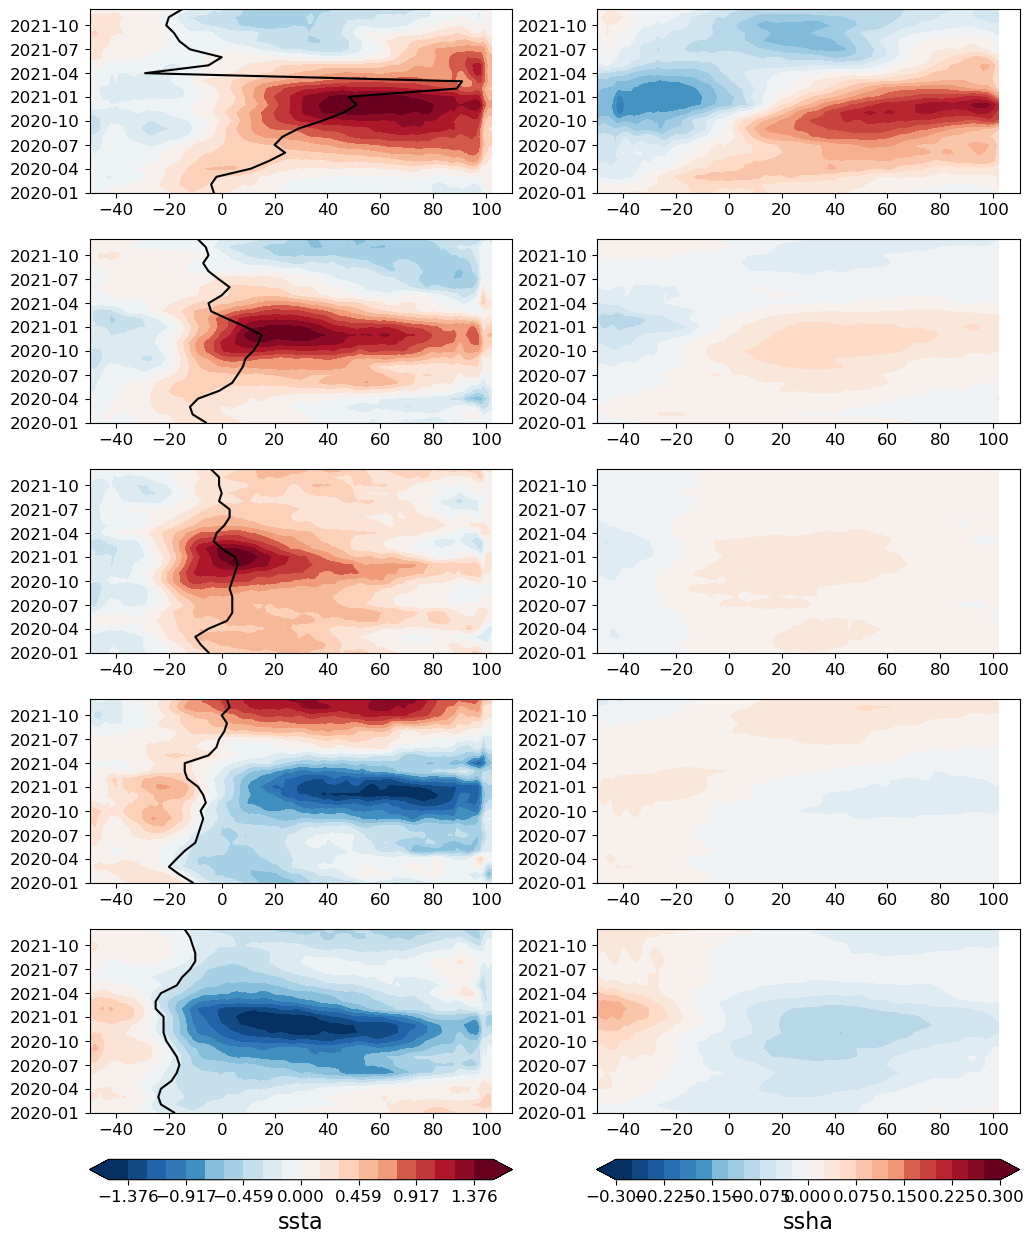

In [9]:
# Plotting
plotspec = {
    'ssta': dict(cmap='RdBu_r', vmin=None, vmax=None, step=None),
    'ssha': dict(cmap='RdBu_r', vmin=-.3, vmax=.3, step=0.025),
}
n_columns = len(weighted_lat_mean.data_vars)
n_rows = len(weighted_lat_mean['classes'])
height_ratios = [9]*(n_rows)
height_ratios.append(1)
fig = plt.figure(figsize=(n_columns*6, n_rows*3 + 0.2))
gs = fig.add_gridspec(n_rows + 1, n_columns,
                      height_ratios=height_ratios,
                      hspace=0.3, wspace=0.2)
axs = []
for j in range(n_columns):
    for i in range(n_rows):
        idx = gmm_order[i] + 1
        var = list(weighted_lat_mean.data_vars)[j]
        lat_mean = weighted_lat_mean[var].sel(classes=idx)
        ax = fig.add_subplot(gs[i, j])
        
        im = vpl.plot_hovmoeller(lat_mean, x='lon', y='time',
                                 ax=ax, **plotspec[var], add_bar=False,
                                 cbkwargs=dict(orientation='vertical', shrink=0.8))

        if var == 'ssta':
            thermocline = []
            for t in profile_mean['time']:
                thermocline.append(warm_pool_edge(profile_mean.sel(time=t, classes=idx), T=29))
            thermocline = xr.DataArray(thermocline, coords={'time': profile_mean['time']})
        
            ax.plot(thermocline.data, thermocline['time'], '-k')
        
        
    # Shared colorbar
    ax = fig.add_subplot(gs[-1, j])
    cbar = plt.colorbar(im['im'], orientation='horizontal', shrink=0.3,
                        cax=ax, extend='both')
    cbar.set_label(f"{var}", size=16)


Sample data and compute means of neutral years.

In [10]:
f_sst = data_filenames[source]
null_hypothesis = 'neutral'
n_samples_mean = 100
n_samples_time = 12

# Null hypothesis
enso_classes = utenso.get_enso_flavors_obs(
    definition='N3N4', fname=f_sst, vname='sst', climatology='month',
    month_range=[12, 2],
)
if null_hypothesis == 'neutral':
    # Neutral years as null hypothesis
    time_snippets_null = np.array(
        [enso_classes.loc[enso_classes['type'] == 'Normal']['start'],
         enso_classes.loc[enso_classes['type'] == 'Normal']['end']]
    ).T
elif null_hypothesis == 'all':
    # All winters as null hypothesis
    time_snippets_null = np.array(
        [enso_classes['start'],
         enso_classes['end']]
    ).T
else:
    raise ValueError(f"Unknown null hypothesis: {null_hypothesis}")

samples_null = []
for var in ds.data_vars:
    da = ds[var]

    # Select years and rearrange
    years = np.unique(np.array(time_snippets_null[:,0], dtype='datetime64[Y]'))
    print(f"Number of years: {len(years)}")
    da_null = []
    for y in years[:-1]:
        # Select time-period each year
        tstart = np.datetime64(f"{y}-{mon_first_year:02d}-01", 'D')
        tend = np.datetime64(f"{y+1}-{mon_second_year:02d}-28", 'D') 
        da_null.append(da.sel(time=slice(tstart, tend)).data)

    # Create Dataarray
    month_coord = np.arange(np.datetime64(tstart, 'M'), np.datetime64(tend, 'M')+1,
                       dtype='datetime64[M]')
    da_null = xr.DataArray(np.array(da_null),
                              coords={'years': np.arange(len(years)-1),
                                      'time': month_coord,
                                      'lat': ds['lat'], 'lon': ds['lon']})
                                    
    # Sample means from null hypothesis
    samples_null_var = []
    for n in range(n_samples_mean):
        samples_idx = np.random.choice(da_null['years'], size=n_samples_time,
                                        replace=True)
        samples_null_var.append(da_null.sel(
            years=samples_idx).mean(dim='years'))
    samples_null_var = xr.concat(samples_null_var, dim='samples')
    samples_null_var.name = var
    samples_null.append(samples_null_var)

samples_null = xr.merge(samples_null)
# Compute lat mean for hovmoeller
samples_null_lat_mean = samples_null.sel(lat=slice(lats[0], lats[1])).mean(dim='lat')

Sort longitudes and latitudes in ascending order, respectively
Number of years: 9


/tmp/ipykernel_105519/3942439700.py:43: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  da_null = xr.DataArray(np.array(da_null),


Number of years: 9


/tmp/ipykernel_105519/3942439700.py:43: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  da_null = xr.DataArray(np.array(da_null),


Statistical significance

In [11]:
alpha = 0.05
multiple_testing='dunn'

masks = []
pvalues = []
for var in list(weighted_lat_mean.data_vars):
    print(f"Percentile of score for {var}")
    # Compute poc in parallel for classes 
    n_processes = len(weighted_lat_mean['classes'])
    results = Parallel(n_jobs=4)(
        delayed(utstats.percentile_of_scores)(
            samples_null_lat_mean[var], weighted_lat_mean[var].isel(classes=i), 
            stackdim=['time', 'lon'], id=i)
        for i in tqdm(range(n_processes))
    )
    # Read results
    indices = []
    pvals = []
    for r in results:
        p, i = r
        indices.append(i)
        pvals.append(p)
    pvals = xr.concat(pvals, dim=weighted_lat_mean['classes'][indices])
    pvalues.append(pvals)

    mask_var = []
    for k in pvals['classes']:
        mask_var.append(utstats.field_significance_mask(
            pvals.sel(classes=k), stackdim=('time', 'lon'), alpha=alpha, corr_type=multiple_testing)
        )
    # Concatenate along classes-dim
    mask_var = xr.concat(mask_var, dim=pvals['classes'])
    mask_var.name = var
    masks.append(mask_var)

pvalues = xr.merge(pvalues)
mask = xr.merge(masks)


Percentile of score for ssta


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 14.36it/s]


Percentile of score for ssha


100%|██████████| 5/5 [00:00<00:00, 2167.15it/s]


Plot weighted hovmoeller averages

/tmp/ipykernel_105519/915726715.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../../output/reanalysis/pcgmm/hovmoeller/"
/mnt/qb/work/goswami/jschloer46/software/mamba/envs/phdenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


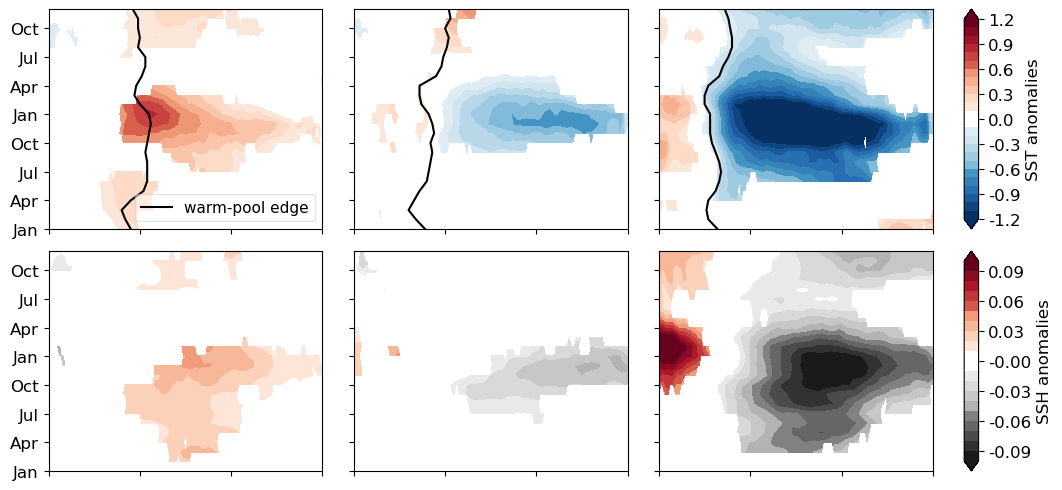

In [40]:
# Plotting
plotspec = {
    'ssta': dict(cmap='RdBu_r', centercolor='#FFFFFF', vmin=-1.2, vmax=1.2, step=0.1),
    'ssha': dict(cmap='RdGy_r', centercolor='#FFFFFF', vmin=-.1, vmax=.1, step=0.01),
}

n_rows = len(weighted_lat_mean.data_vars)
n_columns = len(weighted_lat_mean['classes']) - 2
width_ratios = [19]*(n_columns)
width_ratios.append(1)
fig = plt.figure(figsize=(12, n_rows*3))
gs = fig.add_gridspec(n_rows, n_columns+1, width_ratios=width_ratios,
                      hspace=0.1, wspace=0.15)
axs = []
for i in range(n_rows):
    for j in range(n_columns):
        idx = gmm_order[j+2] + 1
        var = list(weighted_lat_mean.data_vars)[i]
        lat_mean = weighted_lat_mean[var].sel(classes=idx)
        # Statistical significance
        lat_mean_masked = xr.where(mask[var].sel(classes=idx) == True, lat_mean, np.nan)
        ax = fig.add_subplot(gs[i, j])
        
        im = vpl.plot_hovmoeller(lat_mean_masked, x='lon', y='time',
                                 ax=ax, **plotspec[var], add_bar=False)

        # Warm pool edge
        if var == 'ssta':
            thermocline = []
            for t in profile_mean['time']:
                thermocline.append(warm_pool_edge(profile_mean.sel(time=t, classes=idx), T=29))
            thermocline = xr.DataArray(thermocline, coords={'time': profile_mean['time']})
        
            ax.plot(thermocline.data, thermocline['time'], '-k', label='warm-pool edge')

            # Legend
            if (i == 0) and (j==0):
                ax.legend(loc=4, fontsize=11)

        # X-axis
        ax.set_xlim(None, 100)
        if i < n_rows -1:
            ax.set_xticklabels([])
        else:
            # xaxis_formatter = FuncFormatter(lambda x, pos: f'{np.where(x < 0, (x % 180),(x % 180 - 180)):.0f}')
            # ax.xaxis.set_major_formatter(xaxis_formatter)
            # ax.set_xlabel('longitude') 
            ax.set_xticklabels([])
        
        # Y-axis to month
        if j > 0:
            ax.set_yticklabels([])
        else:
            ax.yaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))
        
        axs.append(ax)


    # Shared colorbar
    ax = fig.add_subplot(gs[i, -1])
    cbar = plt.colorbar(im['im'], orientation='vertical', shrink=0.3,
                        cax=ax, extend='both')
    # Colorbar labels
    if var == 'ssta':
        formatter = FuncFormatter(lambda x, pos: f'{x:.1f}')
        cbar.set_label(f"SST anomalies", size=12)
    elif var == 'ssha':
        formatter = FuncFormatter(lambda x, pos: f'{x:.2f}')
        cbar.set_label(f"SSH anomalies", size=12)

    cbar.ax.yaxis.set_major_formatter(formatter)



# Add figure numbering
# _ = vpl.enumerate_subplots(np.array(axs).T, pos_x=0.02, pos_y=.85, fontsize=14)

plt.savefig("../../output/reanalysis/pcgmm/hovmoeller/"
            + f"SI_weighted_mean_pos-test_null-{null_hypothesis}_alpha-{alpha}"
            + f"_n-{n_samples_mean}_t-{n_samples_time}_multitest_{multiple_testing}.png",
            dpi=300, bbox_inches='tight')

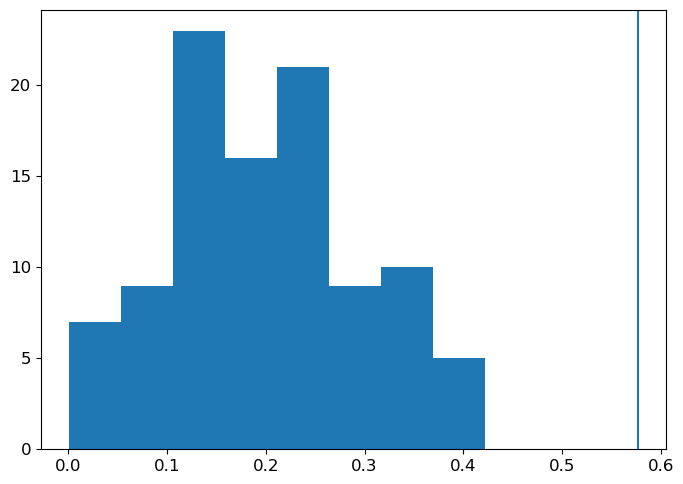

In [13]:
idx_lon = 50
idx_time = 10
var = 'ssta'
fig, ax = plt.subplots()
ax.hist(samples_null_lat_mean[var].isel(lon=idx_lon, time=idx_time).data, bins='auto' )
ax.axvline(weighted_lat_mean[var].isel(lon=idx_lon, time=idx_time, classes=i).data)
#ax.set_xlim(-2, 2)

## Paperplot

/tmp/ipykernel_105519/1583222045.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../../output/reanalysis/pcgmm/hovmoeller/"
/mnt/qb/work/goswami/jschloer46/software/mamba/envs/phdenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


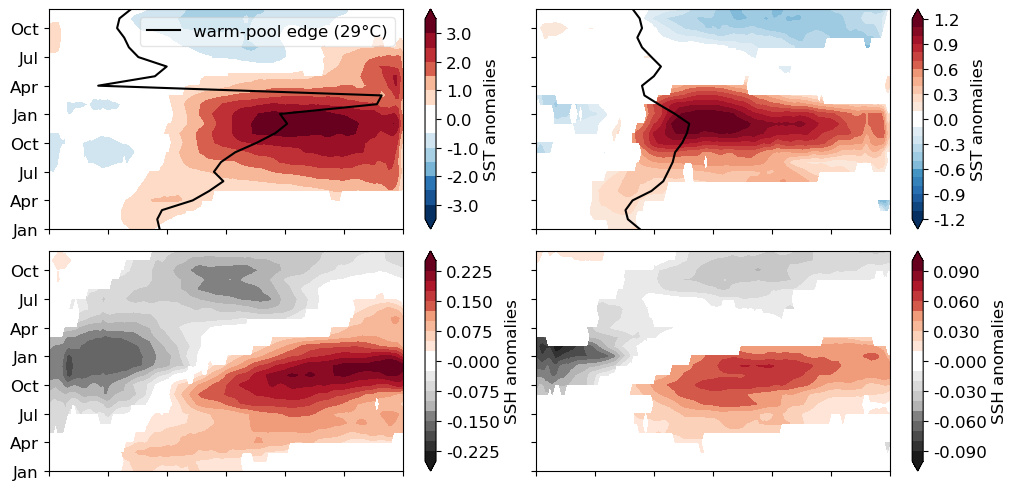

In [44]:
# Plotting
reload(vpl)
plotspec = [
    {'ssta': dict(cmap='RdBu_r', centercolor='#FFFFFF', vmin=-3.5, vmax=3.5, step=.5),
     'ssha': dict(cmap='RdGy_r', centercolor='#FFFFFF', vmin=-.25, vmax=.25, step=0.025)}, 
    {'ssta': dict(cmap='RdBu_r', centercolor='#FFFFFF', vmin=-1.2, vmax=1.2, step=.1),
     'ssha': dict(cmap='RdGy_r', centercolor='#FFFFFF', vmin=-.1, vmax=.1, step=0.01)}, 
]

n_columns = 2
n_rows = len(weighted_lat_mean.data_vars) #len(weighted_lat_mean['classes'])
fig = plt.figure(figsize=(12, n_rows*3))
gs = fig.add_gridspec(n_rows, n_columns,
                      hspace=0.1, wspace=0.1)
axs = []
ims = []
for i in range(n_rows):
    for j in range(n_columns):
        idx = gmm_order[j] + 1
        var = list(weighted_lat_mean.data_vars)[i]
        lat_mean = weighted_lat_mean[var].sel(classes=idx)
        lat_mean_masked = xr.where(mask[var].sel(classes=idx) == True, lat_mean, np.nan)
        ax = fig.add_subplot(gs[i, j])

        if j == 0:
            plkwargs = plotspec[0]
        else:
            plkwargs = plotspec[1]
        
        im = vpl.plot_hovmoeller(lat_mean_masked, x='lon', y='time',
                                 ax=ax, **plkwargs[var], add_bar=True,
                                 cbkwargs=dict(orientation='vertical', shrink=1.0))
        # Colorbar labels
        if var == 'ssta':
            formatter = FuncFormatter(lambda x, pos: f'{x:.1f}')
            im['cb'].set_label(f"SST anomalies", size=12)
        elif var == 'ssha':
            formatter = FuncFormatter(lambda x, pos: f'{x:.3f}')
            im['cb'].set_label(f"SSH anomalies", size=12)

        im['cb'].ax.yaxis.set_major_formatter(formatter)

        if var == 'ssta':
            thermocline = []
            for t in profile_mean['time']:
                thermocline.append(warm_pool_edge(profile_mean.sel(time=t, classes=idx), T=29))
            thermocline = xr.DataArray(thermocline, coords={'time': profile_mean['time']})
        
            ax.plot(thermocline.data, thermocline['time'], '-k', label='warm-pool edge (29°C)')
        
        # X-axis
        ax.set_xlim(None, 100)
        if i < n_rows -1:
            ax.set_xticklabels([])
        else:
            #xaxis_formatter = FuncFormatter(lambda x, pos: f'{np.where(x < 0, (x % 180),(x % 180 - 180)):.0f}')
            #ax.xaxis.set_major_formatter(xaxis_formatter)
            #ax.set_xlabel('longitude') 
            ax.set_xticklabels([])
        
        # Y-axis to month
        if j > 0:
            ax.set_yticklabels([])
        else:
            ax.yaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))
        
        ax.tick_params(axis='both', which='major', labelsize=12)
        
        axs.append(ax)
        ims.append(im)

# Legend
axs[0].legend(loc=1)


# Add figure numbering
#_ = vpl.enumerate_subplots(np.array(axs).T, pos_x=0.02, pos_y=.9, fontsize=14)

plt.savefig("../../output/reanalysis/pcgmm/hovmoeller/"
            + f"weighted_mean_pos-test_null-{null_hypothesis}_alpha-{alpha}"
            + f"_n-{n_samples_mean}_t-{n_samples_time}_multitest_{multiple_testing}.png",
            dpi=300, bbox_inches='tight')